In [1]:
ENV = 'LOCAL'

In [2]:
base_path = './dataset'
%ls
%cd ./dataset

if ENV == "GOOGLE_COLLAB":
  from google.colab import drive
  drive.mount('/content/drive')

  base_path = "/content/drive/MyDrive/Tec/FJ25/IA/M2/project/dataset"

  %cd "/content/drive/MyDrive/Tec/FJ25/IA/M2/project/dataset"
  !ls

print(base_path)

README.md              dataset/               requirements.txt
data-processing.ipynb  dataset-cartas/        scripts/
/Users/danielhurtado/Library/CloudStorage/GoogleDrive-a01707774@tec.mx/My Drive/Tec/FJ25/IA/M2/project/dataset
./dataset


/Users/danielhurtado/Library/CloudStorage/GoogleDrive-a01707774@tec.mx/My Drive/Tec/FJ25/IA/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import cv2

## Data separation

In [4]:
train_dir = 'train'
test_dir = 'test'
validation_dir = 'valid'

In [5]:
print("Contenido de la carpeta TRAIN:")
print(os.listdir(train_dir))  # Esto debe mostrar las categorías dentro de TRAIN

print("Contenido de la carpeta TEST:")
print(os.listdir(test_dir))  # Esto debe mostrar las categorías dentro de TEST

print("Contenido de la carpeta VALIDATION:")
print(os.listdir(validation_dir))  # Esto debe mostrar las categorías dentro de TEST

# También puedes verificar las imágenes dentro de cada subcarpeta:
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        print(f"Imágenes en {category}:")
        print(os.listdir(category_path))  # Lista las imágenes dentro de cada categoría

Contenido de la carpeta TRAIN:
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
Contenido de la carpeta TEST:
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
Contenido de la carpeta VALIDATION:
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
Imágenes en NEUTROPHIL:
['_142_4726.jpeg', '_129_6939.jpeg', '_34_7704.jpeg', '_155_8195.jpeg', '_104_9961.jpeg', '_122_4102.jpeg', '_95_5558.jpeg', '_102_5518.jpeg', '_139_4043.jpeg', '_89_7835.jpeg', '_89_9128.jpeg', '_32_8794.jpeg', '_9_8636.jpeg', '_113_9888.jpeg', '_91_7022.jpeg', '_75_6121.jpeg', '_108_8264.jpeg', '_75_3636.jpeg', '_152_8653.jpeg', '_150_2493.jpeg', '_6_4650.jpeg', '_42_665.jpeg', '_123_7227.jpeg', '_130_2521.jpeg', '_69_6925.jpeg', '_31_942.jpeg', '_101_7927.jpeg', '_105_9654.jpeg', '_90_3987.jpeg', '_37_2457.jpeg', '_1_2146.jpeg', '_112_4249.jpeg', '_105_7426.jpeg', '_77_8249.jpeg', '_87_1916.jpeg', '_98_5779.jpeg', '_77_3405.jpeg', '_85_1637.jpeg', '_117_3346.jpeg', '_39_9868.jpeg', '_144_3282.jpeg', '_

## Scaling and pre processing techniques

In [6]:
def extract_and_resize(img_bgr, target_size=(80,80), visualize=False):
    """
    img_bgr: imagen en BGR (OpenCV)
    target_size: (width, height) final
    """
    # 0. Asegurarse que la imagen es BGR
    if img_bgr.shape[2] != 3:
        raise ValueError("La imagen no es BGR (3 canales)")
    if img_bgr.shape[0] < 80 or img_bgr.shape[1] < 80:
        raise ValueError("La imagen es demasiado pequeña para redimensionar a 80x80")
    # --- Padding para centrar la ROI en un canvas cuadrado (arriba/abajo e izquierda/derecha) ---
    h_img, w_img = img_bgr.shape[:2]
    max_side = max(h_img, w_img)
    # Crear canvas negro cuadrado
    canvas = np.zeros((max_side, max_side, 3), dtype=img_bgr.dtype)
    # Calcular offsets para centrar la imagen original
    y_offset = (max_side - h_img) // 2
    x_offset = (max_side - w_img) // 2
    canvas[y_offset:y_offset + h_img, x_offset:x_offset + w_img] = img_bgr
    img_bgr = canvas

    # 1. Convertir a HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # 2. Crear máscara para rango de púrpura (ajusta según tu imagen)
    lower = np.array([120, 50, 50])
    upper = np.array([160, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    # 3. Encontrar contornos en la máscara
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        # Si no encontró nada, usar toda la imagen como ROI
        x,y,w,h = 0,0, img_bgr.shape[1], img_bgr.shape[0]
    else:
        print(f"Contornos encontrados: {len(contours)}")
        # Tomar el contorno más grande (asumimos es la célula)
        c = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)

    # 4. Recortar la ROI
    roi = img_bgr[y:y+h, x:x+w]

    # 5. Redimensionar a target_size
    roi_resized = cv2.resize(roi, target_size, interpolation=cv2.INTER_AREA)
    if visualize:
        # CLAHE (opcional, aquí solo para visualización)
        lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        lab[...,0] = clahe.apply(lab[...,0])
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

        # Imagen redimensionada para mostrar
        resized = cv2.resize(img_bgr, target_size, interpolation=cv2.INTER_AREA)
        # Aplicar máscara sobre la imagen original
        masked = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

        titles = ["Original 256×256", "CLAHE", "HSV", "Mask", "Result"]
        imgs   = [resized, enhanced, hsv[:,:,0], mask, masked]
        plt.figure(figsize=(15,6))
        for i, (t,im) in enumerate(zip(titles, imgs),1):
            ax = plt.subplot(2,4,i)
            cmap = 'gray' if im.ndim==2 else None
            plt.imshow(im, cmap=cmap)
            ax.set_title(t)
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    

    return roi_resized

In [ ]:
image_size = (80, 80)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range = 0.3,
    # zoom_range=0.3,
    horizontal_flip=True,
    preprocessing_function=extract_and_resize
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# train_steps = 600 // train_generator.batch_size      # 600 imágenes de train
# val_steps   = 200 // validation_generator.batch_size # 200 imágenes de valid
# test_steps  = 200 // test_generator.batch_size       # 200 imágenes de test

Found 7540 images belonging to 4 classes.
Found 2493 images belonging to 4 classes.
Found 2497 images belonging to 4 classes.


Clases detectadas: ['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
Imágenes encontradas en 'MONOCYTE': ['train/MONOCYTE/_4_825.jpeg', 'train/MONOCYTE/_3_8282.jpeg', 'train/MONOCYTE/_8_9083.jpeg', 'train/MONOCYTE/_9_5268.jpeg', 'train/MONOCYTE/_13_9280.jpeg']
Usando muestra: train/MONOCYTE/_11_1499.jpeg
Contornos encontrados: 27


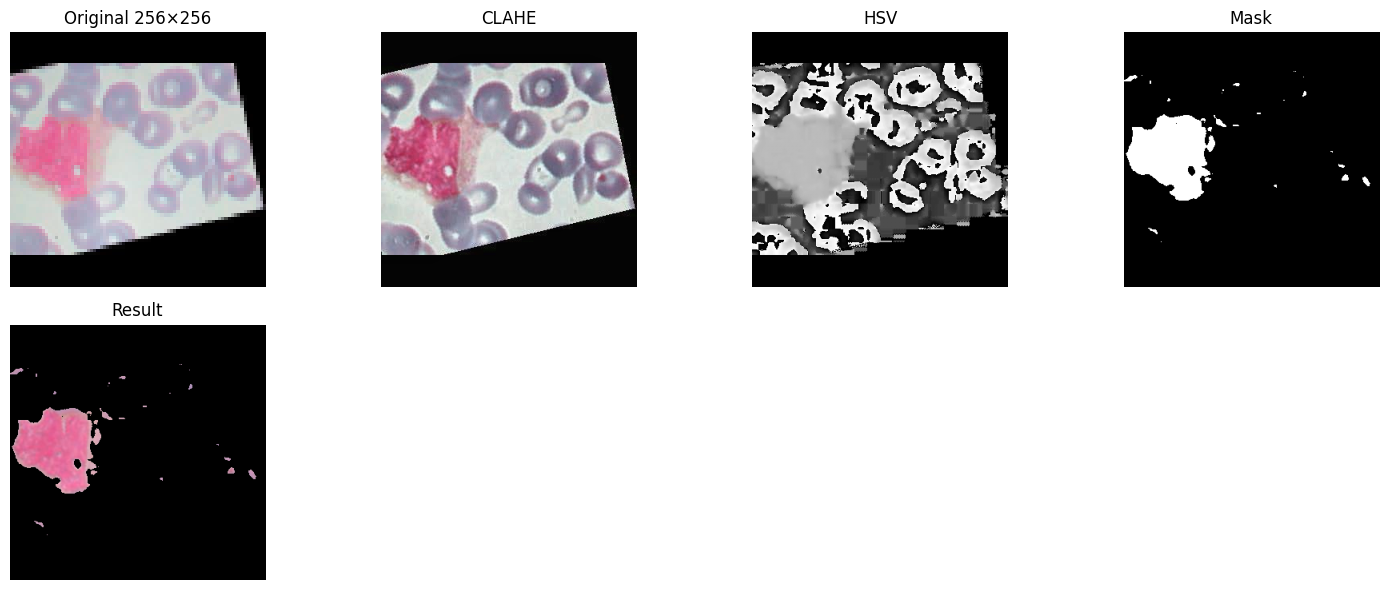

array([[[195, 179, 190],
        [205, 191, 200],
        [211, 202, 210],
        ...,
        [207, 173, 177],
        [203, 165, 175],
        [203, 164, 180]],

       [[184, 166, 180],
        [191, 175, 187],
        [201, 187, 198],
        ...,
        [209, 177, 179],
        [205, 167, 175],
        [203, 161, 176]],

       [[181, 163, 177],
        [183, 168, 181],
        [192, 178, 189],
        ...,
        [209, 177, 179],
        [205, 168, 174],
        [200, 160, 172]],

       ...,

       [[203, 210, 205],
        [203, 210, 205],
        [203, 210, 205],
        ...,
        [215, 216, 220],
        [212, 217, 219],
        [213, 218, 219]],

       [[203, 210, 205],
        [203, 210, 205],
        [203, 210, 205],
        ...,
        [224, 217, 223],
        [222, 223, 226],
        [219, 224, 225]],

       [[203, 210, 205],
        [203, 210, 205],
        [203, 210, 205],
        ...,
        [232, 219, 229],
        [231, 228, 232],
        [222, 227, 227]]

In [8]:
import glob


# 1) Comprueba qué subcarpetas (clases) hay en tu train_dir
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print("Clases detectadas:", classes)

# 2) Toma la primera clase y lista los primeros archivos .png/.jpg
first_cls = classes[1]
pattern = os.path.join(train_dir, first_cls, "*.*")  # puede ser png, jpg, jpeg...
samples = glob.glob(pattern)
print(f"Imágenes encontradas en '{first_cls}':", samples[:5])

# 3) Usa la primera imagen como muestra
sample_path = samples[132]
print("Usando muestra:", sample_path)

# 4) Cárgala y normalízala para nuestro pipeline
img_bgr = cv2.imread(sample_path)
# --- Verifica que no sea None ---
assert img_bgr is not None, f"No se pudo leer {sample_path}"
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype('float32') / 255.0

# 5) Lanza el debug visual
extract_and_resize(img_bgr, visualize=True)

In [9]:
def build_cnn_3conv(input_shape=(80,80,3), num_classes=4):
    """
    input_shape: tamaño de entrada (80,80,3)
    num_classes: número de categorías de salida
    """
    model = models.Sequential()

    # Conv block 1: 16 filtros
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same',
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))  # reduce a 40×40

    # Conv block 2: 32 filtros
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))  # reduce a 20×20

    # Conv block 3: 64 filtros
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))  # reduce a 10×10

    # Aplanar y capa de salida
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = build_cnn_3conv(input_shape=(80,80,3), num_classes=4)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/danielhurtado/Library/CloudStorage/GoogleDrive-a01707774@tec.mx/My Drive/Tec/FJ25/IA/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 80, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        25,604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,188 (192.14 KB)

 Trainable params: 49,188 (192.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    # steps_per_epoch=train_steps,
    validation_data=validation_generator,
    # validation_steps=val_steps,
    epochs=20,
)

# 4) Evaluamos solo con las primeras 200 imágenes de test
loss, acc = model.evaluate(
    test_generator,
    # steps=test_steps
)

print(f"Test accuracy on first 200 samples: {acc:.2%}")

/Users/danielhurtado/Library/CloudStorage/GoogleDrive-a01707774@tec.mx/My Drive/Tec/FJ25/IA/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
